# This code extracts features from nwb files

In [1]:
# import standard libraries

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import scipy
import pandas as pd 
import csv
import math

# import h5py
import h5py
# import feature extractor
import allensdk
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor

# Plotting options
%matplotlib inline

# Change parameters of the Figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

matplotlib.rcParams.update({'font.size': 15})
#plt.style.use(['dark_background'])

In [2]:
# Change parameters of the Figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 13
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size    

# change the backgroud
#plt.style.use(['seaborn-notebook'])

matplotlib.rcParams.update({'font.size': 15})
#plt.style.use(['dark_background'])

In [3]:
# Function to analyze all nwb files

def analyse_nwb_files(path_to_files):
    
    nwb_file_list=list()

    for file in os.listdir(path_to_files):
        if file.endswith(".nwb"):
            nwb_file_list.append(os.path.join(file))

    # create a dictionary of dictionaries
    # to store computed features
    files_features={}
    files_features_AP={}

    # dictionary of dictionaries for firing-rate
    files_features_fI={}

    # dictionaries to record spikes
    voltage_spike=[]
    time_spike=[]

    # dictionaries to record f-I curves
    firing_frequency=[]
    input_current=[]
    
    # lists to record the time to spike
    time_to_spike_input=[]
    time_to_spike_value=[]


    for l in range(0,len(nwb_file_list)):

        # load nwb as h5py
        file_name=path_to_files+str('/')+str(nwb_file_list[l])
        f = h5py.File(file_name,'r')

        # get the list of time series, access by names
        list_timeseries=f.get('acquisition/timeseries/').keys()

        print 'Analyzed file'
        print nwb_file_list[l]
        print '\n'

        print 'There are'
        print len(list_timeseries)
        print 'Sweeps'

        ### Action potential properties: Volate deap after AP (fast through-index)
        

        # Extraction of features for all sweeps
        sweep_characteristics={}

        # load the file
        f = h5py.File(file_name,'r')

        for i in range(1,len(list_timeseries)):

            # prepare the feature drict
            features_dict={}

            voltage_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/data')
            current_name=str('stimulus/presentation/Sweep_')+str(i)+str('/data')
            rate_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/starting_time')
            stim_amp_name=str('stimulus/presentation/Sweep_')+str(i)+str('/stimulus_amplitude_pa')
            rate_name=str('acquisition/timeseries/Sweep_')+str(i)+str('/sampling_rate')
            stim_name=str('stimulus/presentation/Sweep_')+str(i)+str('/aibs_stimulus_name')

            # in mV
            voltage=f[voltage_name].value*1e3    
            # in pA
            current=f[current_name].value*1e12        
            # extracts the sampling rate for a given recording in Hz
            # sampling rate
            sampling_rate=sampling_rate=f[rate_name].value
            
            # substact the baseline from the input current, the average of the last 50 ms
            last_50_ms_steps=int(0.05*sampling_rate)
            current=current - np.mean(current[-last_50_ms_steps:])
            
            # time is in sec
            time = np.arange(0, len(voltage)) * (1.0 / int(sampling_rate))

            # decimate downsampling step if there are spikes
#            if max(voltage) > 0:
            voltage=scipy.signal.decimate(voltage,5)
            current=scipy.signal.decimate(current,5)                    
            time=scipy.signal.decimate(time,5)

                    # check for normal spikes
            if max(voltage) < 100:
                if min(voltage) > - 150:
                    current_amp=f[stim_amp_name].value

                    # record voltage deflection if there is a negative amplitude
                    if current_amp<0:
                        gradient_current=np.gradient(current)
                        signal_max=max(np.gradient(current))
                        signal_min=min(np.gradient(current))
                        # find the first and second indexes of the current step
                        first_ind=np.where(gradient_current == signal_max)[0][0]
                        second_ind=np.where(gradient_current == signal_min)[0][0]
                        # check for the first and second indexes
                        if first_ind>second_ind:
                            start_ind=second_ind
                            end_ind=first_ind
                        elif first_ind<second_ind:
                            start_ind=first_ind
                            end_ind=second_ind
                        # get the average voltage in the middle of the sweep
                        voltage_negative_amp=np.mean(voltage[(int(first_ind+second_ind)/2-int(0.1*sampling_rate)):(int(first_ind+second_ind)/2+int(0.1*sampling_rate))])        

                    # calculates the voltage baseline at the end of each sweep, after application of the test pulse
                    voltage_baseline=np.mean(voltage[0:int(0.1*sampling_rate)])

                    # FITTING THE TIME CONSTANT
                    # the fit is based on current step injections only!
                    if f[stim_name].value == 'Long Square':
                        if max(voltage) <= 0:
                            gradient_current=np.gradient(current)
                            signal_max=max(np.gradient(current))
                            signal_min=min(np.gradient(current))
                            # find the first and second indexes of the current step
                            first_ind=np.where(gradient_current == signal_max)[0][0]
                            second_ind=np.where(gradient_current == signal_min)[0][0]
                            # check for the first and second indexes
                            if first_ind>second_ind:
                                start_ind=second_ind
                                end_ind=first_ind
                            elif first_ind<second_ind:
                                start_ind=first_ind
                                end_ind=second_ind

                            # check for zero stimulus amplitude, if not zero, then fit
                            stim_amp = abs(np.mean(current[start_ind:end_ind]))
                            if stim_amp > 10:            
                                voltage_to_fit=voltage[int(start_ind):int(np.round((start_ind + 0.05*sampling_rate)))]
                                # a, inv_tau, y0, we need inv_tau
                                taum=allensdk.ephys.ephys_features.fit_membrane_time_constant(voltage, time, time[int(start_ind)], time[int(np.round((start_ind + 0.05*sampling_rate)))])
                                    # add time const in ms to features
                                if taum[1]:
                                    features_dict['taum']=(1/taum[1])*1000

                    # calculate the timing of the input stimuli, start and end
                    gradient_current=np.gradient(current)
                    signal_max=max(np.gradient(current))
                    signal_min=min(np.gradient(current))
                    # find the first and second indexes of the current step
                    first_ind=np.where(gradient_current == signal_max)[0][0]
                    second_ind=np.where(gradient_current == signal_min)[0][0]

                    # check for the first and second indexes
                    if first_ind>second_ind:
                        start_ind=second_ind
                        end_ind=first_ind
                    elif first_ind<second_ind:
                        start_ind=first_ind
                        end_ind=second_ind

                    if first_ind == second_ind:
                        start_ind = first_ind
                        end_ind = first_ind

                    #record the start/end time to the dictionary
                    features_dict['stim_start']=time[start_ind]
                    features_dict['stim_end']=time[end_ind]

                    # EXTRACTING SPIKE FEATURES
                    if f[stim_name].value == 'Long Square':
                        sweep = EphysSweepFeatureExtractor(t=time, v=voltage, i=current, start=0, end=time[-1])
                        sweep.process_spikes()

                        # RECORD FEATURES INTO THE DICTIONARY OF DICTIONARIES
                        all_spike_features=sweep.spike_feature_keys()
                        for j in range(0,len(all_spike_features)):
                            features_dict[all_spike_features[j]]=sweep.spike_feature(all_spike_features[j])
                    
                    # record the current in pA into the dictionary
                    features_dict['current_amp']=current_amp
                    # record the voltage deflection in mV into the dictionary
                    
                    if current_amp<0:
                        features_dict['voltage_negative_deflection']=voltage_negative_amp        
                    # record voltage baseline
                    features_dict['voltage_base']=voltage_baseline

                    # Record features in a dict of dict for various sweeps
                    sweep_characteristics[str('Sweep_')+str(i)]=features_dict


                    if f[stim_name].value == 'Long Square':
                        # check if there are spikes at all
                        sweep_name=str('Sweep_')+str(i)
                        if 'threshold_index' in sweep_characteristics[sweep_name]:
                            if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents                            
                                # save the sweep if there is one spike (two spike for test)
                                if len(sweep_characteristics[sweep_name]['threshold_index']) <= 2:                                
                                    # record the spike voltage and time trace per spike
                                    spike_ind_start=sweep_characteristics[sweep_name]['threshold_index'][0]-int(0.005*sampling_rate)
                                    spike_ind_end=sweep_characteristics[sweep_name]['threshold_index'][0]+int(0.005*sampling_rate)
                                    # minimal voltage - first ms after the start
                                    min_voltage=np.mean(voltage[spike_ind_start:(spike_ind_start+int(0.001*sampling_rate))])
                                    voltage_spike.append((voltage[spike_ind_start:spike_ind_end]-min_voltage))
    #                                min_time=min(time[spike_ind_start:spike_ind_end])
    #                                time_spike.append((time[spike_ind_start:spike_ind_end]-min_time)*1000)
                                    min_time=np.arange(0, len((voltage[spike_ind_start:spike_ind_end]-min_voltage))) * (1.0 / int(sampling_rate))
                                    time_spike.append(min_time*1000)



        # create the dictionary

        # store features of a file
        nwb_features={}

        ### Passive properties: membrane constant

        # Estimate the taum from single pulses

        taum_list=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:
            if 'taum' in sweep_characteristics[sweep_name]:
                taum_list.append(sweep_characteristics[sweep_name]['taum'])

        taum_list=np.array(taum_list)

        # Show taum
        print 'Initial taum estimate'
        print taum_list
        print '\n'

        # get only taum between 5 and 100 ms
        taum_list=taum_list[np.where( taum_list < 100 )]
        taum_list=taum_list[np.where( taum_list > 5 )]

        print 'Outliers removed'
        print taum_list

        # compute the values
        mean = np.mean(taum_list)
        sigma = np.std(taum_list)

        print 'The average membrane time constant in ms'
        print np.round(mean,2)

        nwb_features['taum_mean']=mean
        nwb_features['taum_sigma']=sigma

        # plot the taum as a function of sweep number

        taum_list=[]
        sweep_number=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:
                if 'taum' in sweep_characteristics[sweep_name]:
                # get only the small taum between 5 and 100 ms to remove artefacts        
                    if sweep_characteristics[sweep_name]['taum'] <100:            
                        if sweep_characteristics[sweep_name]['taum'] >5:
                            string = sweep_name
                            # just gets the first element from the one valued list
                            number=[int(s) for s in string.split('_') if s.isdigit()][0]

                            sweep_number.append(number)
                            # check for NaNs
                            if sweep_characteristics[sweep_name]['taum']:                                                        
                                taum_list.append(sweep_characteristics[sweep_name]['taum'])

        # plot the results

        ### Passive properties: average voltage

        #
        # plot the taum as a function of sweep number
        voltage_base_list=[]

        # record all tam estimations into the list
        for sweep_name in sweep_characteristics:

                # get only the small taum between 5 and 100 ms to remove artefacts        
        #        if sweep_characteristics[sweep_name]['taum'] <100:            
        #            if sweep_characteristics[sweep_name]['taum'] >5:
                        string = sweep_name                
                        voltage_base_list.append(sweep_characteristics[sweep_name]['voltage_base'])

        # compute the values
        mean = np.mean(voltage_base_list)
        sigma = np.std(voltage_base_list)

        print 'The average membrane potential in mV'
        print np.round(mean,2)

        nwb_features['voltage_base_mean']=mean
        nwb_features['voltage_base_sigma']=sigma


        ### Passive properties: input resistance

        # Calculate and plot the input resistance for negative sweeps

        negative_current=[]
        negative_voltage=[]

        for sweep_name in sweep_characteristics:
            # pick up only the responses with the negative voltage deflections
            if bool(sweep_characteristics[sweep_name].get('voltage_negative_deflection')) == True:
                negative_current.append(sweep_characteristics[sweep_name]['current_amp'])
                negative_voltage.append(sweep_characteristics[sweep_name]['voltage_negative_deflection'] -sweep_characteristics[sweep_name]['voltage_base'])


        # create arrays to fit data
        negative_current=np.array(negative_current)/1e3  # convert to nA
        negative_voltage=np.array(negative_voltage)

        # pick up only currents in a certain range to avoid negative fitting
        pos_idx=np.where((np.array(negative_current)>-0.300) & (np.array(negative_current)<0) & (np.array(negative_voltage)< -5 ) )
        negative_current=[negative_current[i] for i in pos_idx[0]]
        negative_voltage=[negative_voltage[i] for i in pos_idx[0]]
        
        # create a linear fit for the data
        if negative_current:
            if negative_voltage:
                A = np.vstack([negative_current, np.ones(len(negative_current))]).T
                m, c = np.linalg.lstsq(A, negative_voltage)[0]
                nwb_features['R_in']=m                
        else:
            nwb_features['R_in']=np.nan
            
        print 'Input resistance in MOhm'
        print nwb_features['R_in']

        ## Active properties

        ### Active properties: f-I curve

        # Plot the f-I curve

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of input currents
        stim_input=[]
        # list of resulting frequencies
        spike_freq=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # INPUT PROCESSING
            if stimulus_type_name == 'Long Square':
                stimulus_path=str("stimulus/presentation/") +str(sweep_name) +str('/stimulus_amplitude_pa')
                stimulus_value=f[stimulus_path].value # to get the pA out of A
                # record the input current
                stim_input.append(stimulus_value)

                # SPIKES PROCESSING        
                if 'peak_t' in sweep_characteristics[sweep_name]:

                     stimulus_start_path=str("stimulus/presentation/") +str(sweep_name) +str('/starting_time')
                     all_spikes=sweep_characteristics[sweep_name]['peak_t']
                     num_spikes=len(all_spikes)
                     spike_freq.append(num_spikes/1) # all spikes during the trial

                # if there are no spikes, add 0
                else:
                    spike_freq.append(0)

        ### Active properties: f-I curve slope


        #data for the fit
        
        pos_idx=np.where((np.array(spike_freq)>0.5) & (np.array(stim_input)>0))
        
        input_value=[stim_input[i] for i in pos_idx[0]]
        feature_value=[spike_freq[i] for i in pos_idx[0]]

        #extract the theobase current and minimal frequency
        try:
            min_freq=min(feature_value)
            # get the value of the minimal element
            pos_min=np.argmin(feature_value)
            min_curr=input_value[pos_min]        
            # save the rheobase current and frequency
            nwb_features['Rheobase_current']=min_curr
            nwb_features['Rheobase_freq']=min_freq
        except (ValueError, RuntimeError, TypeError, NameError):
            nwb_features['Rheobase_current']=np.nan
            nwb_features['Rheobase_freq']=np.nan


        # REMOVE NON-UNIQUE VALUES FROM TWO LISTS!
        input_value_unique=[]
        feature_value_unique=[]    
        # convert them to arrays
        input_value_unique=np.array(input_value)
        feature_value_unique=np.array(feature_value)
        # rounding step
        input_value_unique=np.around(input_value_unique,decimals=0)

        # get only unique in input current elemnts
        input_value_unique, idx_unique = np.unique(input_value_unique, return_index=True)
        feature_value_unique=feature_value_unique[idx_unique]
        try:
            
            # correction for nA case
            if max(input_value_unique)<1:
                input_value_unique=input_value_unique*1e12

            # insert zero values until input current
            zero_steps=np.arange(0,min(input_value_unique)-1,1)
            input_value_unique=np.concatenate((zero_steps, input_value_unique), axis=0)
            zero_freq=np.zeros(len(zero_steps))
            feature_value_unique=np.concatenate((zero_freq, feature_value_unique), axis=0)

            # save the f-I curves data
            input_current.append(input_value_unique)
            firing_frequency.append(feature_value_unique)    


            #Make a linear fit
            A = np.vstack([input_value, np.ones(len(input_value))]).T

            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['fI_slope']=m
            
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['fI_slope']=np.nan
                        

        # save fI slope


        ### Active properties: relative average peak voltage

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        voltage_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike

                # check if there are spikes at all
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                voltage_value.append(sweep_characteristics[sweep_name]['peak_v'][0]-sweep_characteristics[sweep_name]['threshold_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print voltage_value
                                print input_value


        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(input_value))]).T
        try:
            m, c = np.linalg.lstsq(A, voltage_value)[0]
            nwb_features['AP_height_slope']=m
            nwb_features['AP_height_rheobase']=voltage_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_height_slope']=np.nan
            nwb_features['AP_height_rheobase']=np.nan




        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average peak voltage'
        print np.round(voltage_value,2)
        print '\n'
        print 'Average peak voltage'
        print np.round(np.mean(voltage_value),2)

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        width_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                if sweep_characteristics[sweep_name]['width'][0]:
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                    width_value.append(sweep_characteristics[sweep_name]['width'][0]*1000)
                            except (ValueError, RuntimeError, TypeError, NameError, IndexError):
                                print input_value
                                print width_value


        #Make a linear fit
        try:
            A = np.vstack([input_value, np.ones(len(width_value))]).T
            m, c = np.linalg.lstsq(A, width_value)[0]
            nwb_features['AP_width_slope']=m
            nwb_features['AP_width_rheobase']=width_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_width_slope']=np.nan
            nwb_features['AP_width_rheobase']=np.nan




        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average peak width in ms'
        print np.round(width_value,2)
        print '\n'
        print 'Average AP widtj trials in mV'
        print np.round(np.mean(width_value),2)
        print '\n'
        print 'Average threshold std in mV'
        print np.round(np.std(width_value),2)


        # export to eps
        #plt.savefig('W1_AP_width.eps', format='eps', dpi=300)



        ### Active properties: AP voltage treshold

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        thr_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                thr_value.append(sweep_characteristics[sweep_name]['threshold_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print thr_value
                                print input_value

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(thr_value))]).T
        try:
            m, c = np.linalg.lstsq(A, thr_value)[0]
            nwb_features['AP_thr_slope']=m
            nwb_features['AP_thr_rheobase']=thr_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_thr_slope']=np.nan
            nwb_features['AP_thr_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'AP threshold value in mV'
        print np.round(thr_value,2)
        print '\n'

        print 'Average start in mV'
        print np.round(np.mean(thr_value),2)
        print '\n'
        print 'Average start std in mV'
        print np.round(np.std(thr_value),2)

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                feature_value.append(sweep_characteristics[sweep_name]['fast_trough_v'][0])
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except (ValueError, RuntimeError, TypeError, NameError, IndexError):
                                print input_value
                                print feature_value

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_through_slope']=m
            nwb_features['AP_through_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_through_slope']=np.nan
            nwb_features['AP_through_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage trough after AP'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in mV'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in mV'
        print np.round(np.std(feature_value),2)




        ### Action potential properties: AP voltage upstroke

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            feature_value.append(sweep_characteristics[sweep_name]['upstroke_v'][0])

        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_upstroke_slope']=m
            nwb_features['AP_upstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_upstroke_slope']=np.nan
            nwb_features['AP_upstroke_rheobase']=np.nan

            
        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage trough after AP in mV/ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in mV/ms'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in mV/ms'
        print np.round(np.std(feature_value),2)


        ### Action potential properties: AP voltage downstroke

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                try:
                                    feature_value.append(sweep_characteristics[sweep_name]['downstroke_v'][0])
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                except (ValueError, RuntimeError, TypeError, NameError, IndexError, KeyError):
                                    print feature_value
                                    print input_value


        #Make a linear fit
        A = np.vstack([input_value, np.ones(len(feature_value))]).T
        try:
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_downstroke_slope']=m
            nwb_features['AP_downstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_downstroke_slope']=np.nan
            nwb_features['AP_downstroke_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage trough after AP in mV/ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in mV/ms'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in mV/ms'
        print np.round(np.std(feature_value),2)


        ### Action potential properties: AP volage upstroke/downstroke ratio

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                try:
                                    feature_value.append(sweep_characteristics[sweep_name]['upstroke_downstroke_ratio'][0])
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                except (ValueError, RuntimeError, TypeError, NameError, IndexError, KeyError):
                                    print feature_value
                                    print input_value
                                

        #Make a linear fit
        try:
            A = np.vstack([input_value, np.ones(len(feature_value))]).T
            m, c = np.linalg.lstsq(A, feature_value)[0]
            nwb_features['AP_up/downstroke_slope']=m
            nwb_features['AP_up/downstroke_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['AP_up/downstroke_slope']=np.nan
            nwb_features['AP_up/downstroke_rheobase']=np.nan

        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Voltage upstroke/downstroke ratio'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in []'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in []'
        print np.round(np.std(feature_value),2)

        ### Active properties, spike patterns: adaptation index

        # Plot the average adaptation index as a function of the input current

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        index_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                                isis=sweep_characteristics[sweep_name]['peak_t']          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                isis=allensdk.ephys.ephys_features.adaptation_index(isis) # compute the adaptation index
                                index_value.append(isis)                                  # record the index
                                
        # convert not index
        index_value=np.array(index_value)
        #get the nan index value
        nan_index=np.argwhere(np.isnan(index_value))
        # remove elements with the wrong index value
        index_value = index_value[np.isfinite(index_value)]
        # remove the corresponding element in input value if it is needed
        if len(nan_index)>0:
            input_value = [i for j, i in enumerate(input_value) if j not in nan_index]
            
        

        #Make a linear fit        
        x=np.array(input_value)
        y=np.array(index_value)

        # take only positive values
        x=x[np.where(y>0)]
        y=y[np.where(y>0)]


        #Make a linear fit
        A = np.vstack([x, np.ones(len(x))]).T
        try:
            m, c = np.linalg.lstsq(A, y)[0]
            # save the adaptation index
            nwb_features['adaptation_slope']=m
            nwb_features['adaptation_slope_rheobase']=y[np.argmin(x)]
        except (ValueError,RuntimeError, TypeError, NameError):
                nwb_features['adaptation_slope']=np.nan
                nwb_features['adaptation_slope_rheobase']=np.nan

                
        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Adaptation index value'
        print np.round(index_value,2)
        print '\n'
        print 'Average adaptation index over trials'
        print np.round(np.mean(index_value),2)


        ### Active properties, spike patterns: average interspike interval

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                if len(isis) >=1:
                                    input_value.append(np.mean(sweep_characteristics[sweep_name]['peak_i'][0]))                
                                    feature_value.append(np.mean(isis))                       # compute the average value of ISIs

        #Make an exponential fit
        x=np.array(input_value)
        y=np.array(feature_value)
        
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['mean_ISI_slope']=coeff[0]
            nwb_features['mean_ISI_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['mean_ISI_slope']=np.nan
            nwb_features['mean_ISI_slope_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average interspike interval in ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in []'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in []'
        print np.round(np.std(feature_value),2)


        ### Active properties, spike patterns: first ISI

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                                isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                isis=np.diff(isis)                                        # compute the inter-spike intervals
                                if len(isis) >=1:
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])                
                                    feature_value.append(isis[0])                       # compute the average value of ISIs

        #Make an exponential fit
        x=np.array(input_value)
        y=np.array(feature_value)
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['First_ISI_slope']=coeff[0]
            nwb_features['First_ISI_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['First_ISI_slope']=np.nan
            nwb_features['First_ISI_slope_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Average interspike interval in ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in []'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in []'
        print np.round(np.std(feature_value),2)


        ### Active properties, spike patterns: first spike delay

        # Plot the average peak voltage as a function of the stimulus

        # load the NWB file
        f = h5py.File(file_name,'r')

        #list of instantaneous input currents
        input_value=[]
        # list of instantaneous voltages
        feature_value=[]

        # Over the range of long square sweeps
        for sweep_name in sweep_characteristics:

            # check the stimulus for name
            stimulus_type_path=str('stimulus/presentation/') +str(sweep_name) +str('/aibs_stimulus_name')
            stimulus_type_name= str(f[stimulus_type_path].value)

            # currents processing
            if stimulus_type_name == 'Long Square':        
                # Record the threshold voltage for the first spike
                if 'peak_v' in sweep_characteristics[sweep_name]:
                    if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) >0:   # only for positive currents
                        if np.mean(sweep_characteristics[sweep_name]['peak_i'][0]) < 800:   # only for positive currents
                            try:
                                if (sweep_characteristics[sweep_name]['stim_end'] - sweep_characteristics[sweep_name]['stim_start'])*1000 > 800:
                                    feature_value.append((sweep_characteristics[sweep_name]['peak_t'][0]-sweep_characteristics[sweep_name]['stim_start'])*1000)               
                                    isis=sweep_characteristics[sweep_name]['peak_t']*1000          # grab AP peak time
                                    isis=np.diff(isis)                                        # compute the inter-spike intervals
                                    input_value.append(sweep_characteristics[sweep_name]['peak_i'][0])
                            except:
                                print feature_value
                                print input_value
                      # compute the average value of ISIs
 

        # Make a linear fit
        x=np.array(input_value)
        y=np.array(feature_value)
        
        # record time_to_spike_values
        time_to_spike_input=time_to_spike_input+input_value
        time_to_spike_value=time_to_spike_value+feature_value
        
        try:
            coeff=np.polyfit(x, np.log(y), 1, w=np.sqrt(y))
            nwb_features['Time_to_spike_slope']=coeff[0]    
            nwb_features['Time_to_spike_slope_rheobase']=feature_value[input_value.index(min(input_value))]
        except (ValueError,RuntimeError, TypeError, NameError):
            nwb_features['Time_to_spike_slope']=np.nan
            nwb_features['Time_to_spike_slope_rheobase']=np.nan


        print 'Input current in pA'
        print np.round(input_value,2)
        print '\n'
        print 'Time to 1st spike in ms'
        print np.round(feature_value,2)
        print '\n'

        print 'Mean in ms'
        print np.round(np.mean(feature_value),2)
        print '\n'
        print 'Std in ms'
        print np.round(np.std(feature_value),2)

        # add first spikes to the dictionary of dictionaries
        files_features_AP['first_spike_voltage']=voltage_spike
        files_features_AP['first_spike_time']=time_spike

        files_features_fI['input_current']=input_current
        files_features_fI['firing_frequency']=firing_frequency


        # record features into the dictionary of dictionaries
        files_features[nwb_file_list[l]]=nwb_features

        
    return files_features, files_features_AP, files_features_fI, time_to_spike_input, time_to_spike_value


In [4]:
# this function creates the list from files features

def matrix_from_dict(n_cells,n_features,label,files_features_dict):
    
    # +1 to add labels
    all_features_matrix=np.zeros((len(files_features_dict.keys()),n_features+1))

    # file_names list
    file_names=[]

    # counter for file names
    k=0
    
    for key in enumerate(files_features_dict.keys()):
        # save the filename
        file_names.append(key[1])
        
        # counter for features
        m=0
        
        # feature name list
        feature_names=[]
        
        for keys in enumerate(files_features_dict[key[1]]):
            # save features to the matrix
            all_features_matrix[k,0]=label
            m=m+1
            all_features_matrix[k,m]=files_features_dict[key[1]][keys[1]]
            feature_names.append(keys[1])
            
        k=k+1

    return all_features_matrix, file_names, feature_names

In [6]:
# WG1

files_features_WG1, files_features_AP_WG1, files_features_fI_WG1, time_to_spike_input_WG1, time_to_spike_value_WG1 = analyse_nwb_files('./Data/WG1/')



Analyzed file
1706014110201.nwb


There are
37
Sweeps


/Users/Anatoly/anaconda2/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/allensdk/ephys/ephys_features.py:820: RuntimeWarning: invalid value encountered in sqrt
  rsme = np.sqrt(np.mean(pred - v_window))


Initial taum estimate
[1.85331783 1.76746615 2.46847758 1.85336508 1.66511789 1.85337019
 2.47026053 2.27382852 2.09573646 2.27309328 2.46832967 1.66516302
 1.70666147 2.09565806 2.09569947 1.70659826 1.76745591 1.70658306
 1.76747473 1.66516055]


Outliers removed
[]
The average membrane time constant in ms
nan
The average membrane potential in mV
-74.85
Input resistance in MOhm
149.49367749217953
Input current in pA
[338.5   99.   281.4  306.82 218.8  313.88 255.43  98.99 149.05 123.56
  99.   176.59 194.72 176.67 149.05 123.54]


Average peak voltage
[126.44  88.08 122.58 114.1  120.15 121.37 109.3   88.53  98.41  99.25
  88.2   92.95  96.41  93.04  98.4   99.44]


Average peak voltage
103.54
Input current in pA
[338.5   99.   281.4  306.82 218.8  313.88 255.43  98.99 149.05 123.56
  99.   176.59 194.72 176.67 149.05 123.54]


Average peak width in ms
[1.98 2.47 2.47 2.47 2.47 1.98 1.98 2.47 1.98 2.47 2.47 2.47 1.98 2.47
 1.98 2.47]


Average AP widtj trials in mV
2.29


Average thr

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:327: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:431: FutureWarning: `rcond` para


[338.5   99.   281.4  306.82 218.8  313.88 255.43  98.99 149.05 123.56
  99.   176.59 194.72 176.67 149.05 123.54]


Time to 1st spike in ms
[ 1.48 11.86  1.98  1.98  2.47  1.48  1.98 11.86  3.95  5.93 11.86  2.97
  2.47  2.97  3.95  5.93]


Mean in ms
4.7


Std in ms
3.68
Analyzed file
1706014110202.nwb


There are
31
Sweeps
Initial taum estimate
[3.6531293  3.31097584 3.3513873  2.99999566 3.17340159 3.22088468
 3.12447558 3.26706978 3.48865345 3.42420285 3.07809893 3.26780784
 3.13551353 3.05578828 3.01220795 3.03152534]


Outliers removed
[]
The average membrane time constant in ms
nan
The average membrane potential in mV
-90.31
Input resistance in MOhm
169.8090228892661
Input current in pA
[302.53 289.46 331.36 178.   269.5  158.17 247.7  226.48 188.07 167.97
 148.28 206.74]


Average peak voltage
[112.59 102.92 115.97 100.47 106.35 101.08 109.86 101.76 104.58 108.16
  95.3  110.2 ]


Average peak voltage
105.77
Input current in pA
[302.53 289.46 331.36 178.   269.5  158.17 247.7

Initial taum estimate
[13.16023621 12.03481348 10.05916166 10.02633802 11.23081634  9.98339493
  9.99259809 10.25968451 10.34847097 10.17245866 10.43558033 10.08964182
 17.25755188 14.72064349 19.28747613]


Outliers removed
[13.16023621 12.03481348 10.05916166 10.02633802 11.23081634  9.98339493
  9.99259809 10.25968451 10.34847097 10.17245866 10.43558033 10.08964182
 17.25755188 14.72064349 19.28747613]
The average membrane time constant in ms
11.94
The average membrane potential in mV
-87.94
Input resistance in MOhm
171.20217932667092
Input current in pA
[158.17 138.39 286.4  266.93 247.01 148.28 207.61 187.82 168.05 128.51
 227.32]


Average peak voltage
[ 83.01  85.69  94.97 100.27  93.49  92.24  86.73  88.8   95.66  77.12
  90.26]


Average peak voltage
89.84
Input current in pA
[158.17 138.39 286.4  266.93 247.01 148.28 207.61 187.82 168.05 128.51
 227.32]


Average peak width in ms
[1.98 1.98 2.47 2.47 1.98 1.98 2.47 2.47 1.98 1.98 2.47]


Average AP widtj trials in mV
2.2


Av

Analyzed file
1706015210902.nwb


There are
29
Sweeps
Initial taum estimate
[22.87008111 22.97107372 23.06698879 23.15205478 23.22639215 23.35947911
 23.41591235 23.29647366 23.25510503 22.88595564 23.92052918 22.69666577
 22.65380747 22.68508453 29.43989006 26.77294149 24.44545177 25.26520926]


Outliers removed
[22.87008111 22.97107372 23.06698879 23.15205478 23.22639215 23.35947911
 23.41591235 23.29647366 23.25510503 22.88595564 23.92052918 22.69666577
 22.65380747 22.68508453 29.43989006 26.77294149 24.44545177 25.26520926]
The average membrane time constant in ms
23.85
The average membrane potential in mV
-94.28
Input resistance in MOhm
198.31580778317166
Input current in pA
[207.59 286.68 266.9  247.13 227.36 158.17 168.05 187.82]


Average peak voltage
[ 96.74 103.04 101.28  95.    97.87  88.18  93.85  90.45]


Average peak voltage
95.8
Input current in pA
[207.59 286.68 266.9  247.13 227.36 158.17 168.05 187.82]


Average peak width in ms
[2.97 2.97 2.97 2.97 2.97 2.97 3.46 2.

Analyzed file
1706015210907.nwb


There are
27
Sweeps
Initial taum estimate
[11.65176381 13.84084258 11.18248393 11.24451958 12.69466965 12.04935436
 11.63595678 11.33647481 11.43710802 14.83142313 11.92090481 11.73708267
 11.83207971 11.54167976 11.16414741]


Outliers removed
[11.65176381 13.84084258 11.18248393 11.24451958 12.69466965 12.04935436
 11.63595678 11.33647481 11.43710802 14.83142313 11.92090481 11.73708267
 11.83207971 11.54167976 11.16414741]
The average membrane time constant in ms
12.01
The average membrane potential in mV
-88.22
Input resistance in MOhm
168.24205367687077
Input current in pA
[247.09 227.35 266.86 168.05 148.28 207.6  187.82 128.51 118.62]


Average peak voltage
[103.71  93.69  93.13 100.72  94.34  91.27 101.94  89.94  90.  ]


Average peak voltage
95.42
Input current in pA
[247.09 227.35 266.86 168.05 148.28 207.6  187.82 128.51 118.62]


Average peak width in ms
[2.47 2.47 2.47 2.47 1.98 2.47 2.47 1.98 2.47]


Average AP widtj trials in mV
2.36


Av

In [7]:
# show the extracted features

files_features_WG1

{'1706014110201.nwb': {'AP_downstroke_rheobase': 38.77232373346675,
  'AP_downstroke_slope': 0.0163803031053365,
  'AP_height_rheobase': 88.52905614906605,
  'AP_height_slope': 0.14592809089966552,
  'AP_thr_rheobase': -49.7567324155993,
  'AP_thr_slope': -0.11462251633010107,
  'AP_through_rheobase': -68.07327523643707,
  'AP_through_slope': 0.04778778578029402,
  'AP_up/downstroke_rheobase': 1.850660467672193,
  'AP_up/downstroke_slope': 0.0014020319286872816,
  'AP_upstroke_rheobase': -40.980862792126906,
  'AP_upstroke_slope': -0.01194705936925167,
  'AP_width_rheobase': 2.4713827283469048,
  'AP_width_slope': -0.0011487349478075985,
  'First_ISI_slope': -0.03049218292916151,
  'First_ISI_slope_rheobase': 564.4638170584399,
  'R_in': 149.49367749217953,
  'Rheobase_current': 100.224304,
  'Rheobase_freq': 1,
  'Time_to_spike_slope': -0.01002559876713322,
  'Time_to_spike_slope_rheobase': 11.862637113835728,
  'adaptation_slope': -6.839699473959901e-05,
  'adaptation_slope_rheobase'

In [9]:
# WG4

files_features_WG4, files_features_AP_WG4, files_features_fI_WG4, time_to_spike_input_WG4, time_to_spike_value_WG4 = analyse_nwb_files('./Data/WG4/')



Analyzed file
1606013050102.nwb


There are
15
Sweeps
Initial taum estimate
[13.82109157 12.13895299 10.76403779 11.30691603 11.7389084  11.26807563
 10.69930336]


Outliers removed
[13.82109157 12.13895299 10.76403779 11.30691603 11.7389084  11.26807563
 10.69930336]
The average membrane time constant in ms
11.68
The average membrane potential in mV
-89.1
Input resistance in MOhm
124.50348850819715
Input current in pA
[446.93 197.71 395.04 345.66 494.96 296.61]


Average peak voltage
[101.97  87.64  96.77  95.98  99.05  94.54]


Average peak voltage
95.99
Input current in pA
[446.93 197.71 395.04 345.66 494.96 296.61]


Average peak width in ms
[1.98 1.98 1.48 1.48 1.98 1.48]


Average AP widtj trials in mV
1.73


Average threshold std in mV
0.25
Input current in pA
[446.93 197.71 395.04 345.66 494.96 296.61]


AP threshold value in mV
[-54.64 -49.61 -51.12 -50.74 -56.06 -50.01]


Average start in mV
-52.03


Average start std in mV
2.43
Input current in pA
[446.93 197.71 395.04 345.6

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:327: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:431: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:479: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warni

Initial taum estimate
[6.37503724 3.27223847 3.97819199 5.06860665]


Outliers removed
[6.37503724 5.06860665]
The average membrane time constant in ms
5.72
The average membrane potential in mV
-65.74
Input resistance in MOhm
nan
Input current in pA
[496.72 441.43  98.86 198.23 148.21 401.66 341.57 299.45 247.71]


Average peak voltage
[109.37 129.75  88.94 105.26 104.32 104.1  100.8  110.07 103.28]


Average peak voltage
106.21
Input current in pA
[496.72 441.43  98.86 198.23 148.21 401.66 341.57 299.45 247.71]


Average peak width in ms
[2.47 2.47 2.47 2.47 2.47 2.47 2.47 2.47 2.47]


Average AP widtj trials in mV
2.47


Average threshold std in mV
0.0
Input current in pA
[496.72 441.43  98.86 198.23 148.21 401.66 341.57 299.45 247.71]


AP threshold value in mV
[-60.35 -76.14 -46.44 -53.95 -51.96 -57.26 -55.68 -56.11 -52.87]


Average start in mV
-56.75


Average start std in mV
7.77
Input current in pA
[496.72 441.43  98.86 198.23 148.21 401.66 341.57 299.45 247.71]


Voltage troug

Initial taum estimate
[3.61673344 8.96010085 6.12802273 2.93109551 3.74065129 5.94755985
 3.15326124 3.63534968 3.63091237 3.11711344 3.22452569 3.19316466
 5.75123383 5.60868181 3.34772622]


Outliers removed
[8.96010085 6.12802273 5.94755985 5.75123383 5.60868181]
The average membrane time constant in ms
6.48
The average membrane potential in mV
-80.11
Input resistance in MOhm
61.070107734538645
Input current in pA
[507.46 451.25 658.91 302.69 252.17 608.48 549.57 201.89 351.68 403.34]


Average peak voltage
[103.47  93.88 102.25 102.46  92.45 100.48 104.35  96.17 102.47 100.01]


Average peak voltage
99.8
Input current in pA
[507.46 451.25 658.91 302.69 252.17 608.48 549.57 201.89 351.68 403.34]


Average peak width in ms
[1.98 2.47 2.47 2.47 2.47 2.47 2.47 2.47 2.47 1.98]


Average AP widtj trials in mV
2.37


Average threshold std in mV
0.2
Input current in pA
[507.46 451.25 658.91 302.69 252.17 608.48 549.57 201.89 351.68 403.34]


AP threshold value in mV
[-51.52 -51.13 -55.   -

Analyzed file
1706012210403.nwb


There are
27
Sweeps
Initial taum estimate
[29.76086766 30.14203744 31.86990296 40.78964412 40.72998173 30.97178595
 29.76353846 30.14537741 30.96906866 30.14274727 29.76315748 40.88204438
 30.97114718 31.86862156 31.86822469]


Outliers removed
[29.76086766 30.14203744 31.86990296 40.78964412 40.72998173 30.97178595
 29.76353846 30.14537741 30.96906866 30.14274727 29.76315748 40.88204438
 30.97114718 31.86862156 31.86822469]
The average membrane time constant in ms
32.71
The average membrane potential in mV
-78.15
Input resistance in MOhm
173.00256298528308
Input current in pA
[498.64 449.49 647.12 300.02 250.16 600.57 548.39 100.17 100.3  349.58
 399.59]


Average peak voltage
[106.32 103.73  98.02 102.02 100.76 103.54 105.09  95.78  95.97 101.36
 104.98]


Average peak voltage
101.6
Input current in pA
[498.64 449.49 647.12 300.02 250.16 600.57 548.39 100.17 100.3  349.58
 399.59]


Average peak width in ms
[2.47 2.47 2.47 2.47 2.47 2.47 2.47 2.47 2.

Initial taum estimate
[10.04829546  9.91134177  9.93509162  9.90319543  9.89961241  9.93887854
  9.89957304  9.93511079 11.05708642 12.10772398 10.05173529  9.91117947
 11.05849508 10.05151486  9.91467338]


Outliers removed
[10.04829546  9.91134177  9.93509162  9.90319543  9.89961241  9.93887854
  9.89957304  9.93511079 11.05708642 12.10772398 10.05173529  9.91117947
 11.05849508 10.05151486  9.91467338]
The average membrane time constant in ms
10.24
The average membrane potential in mV
-85.26
Input resistance in MOhm
102.41594063196393
Input current in pA
[600.47 450.04 550.4  500.09 745.23 702.17 647.21]


Average peak voltage
[ 98.91  93.07  94.14  99.59 103.94 110.55 101.12]


Average peak voltage
100.19
Input current in pA
[600.47 450.04 550.4  500.09 745.23 702.17 647.21]


Average peak width in ms
[2.47 2.47 2.47 2.47 2.47 2.47 2.47]


Average AP widtj trials in mV
2.47


Average threshold std in mV
0.0
Input current in pA
[600.47 450.04 550.4  500.09 745.23 702.17 647.21]


AP

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/allensdk/ephys/ephys_features.py:470: RuntimeWarning: invalid value encountered in less
  thresh_to_peak_levels[width_levels < v[spike_indexes]]


Initial taum estimate
[4.24802159 4.20385357 4.32396269 4.26294289 4.21911205 4.2479792
 4.20386407 4.3239098  4.33997352]


Outliers removed
[]
The average membrane time constant in ms
nan
The average membrane potential in mV
-79.62
Input resistance in MOhm
342.7457052038211
Input current in pA
[ 99.64  50.25 458.27 407.29 360.31 295.02 203.95 246.1   50.18  99.62
 150.33]


Average peak voltage
[109.03  99.82 122.48 130.21 118.21 113.75 108.32 110.91 100.05 109.04
 109.05]


Average peak voltage
111.9
Input current in pA
[ 99.64  50.25 458.27 407.29 360.31 295.02 203.95 246.1   50.18  99.62
 150.33]


Average peak width in ms
[2.47 1.98 1.98 2.47 1.98 2.47 1.98 1.98 1.98 2.47 1.98]


Average AP widtj trials in mV
2.16


Average threshold std in mV
0.24
Input current in pA
[ 99.64  50.25 458.27 407.29 360.31 295.02 203.95 246.1   50.18  99.62
 150.33]


AP threshold value in mV
[-55.31 -51.05 -77.78 -77.54 -65.92 -66.49 -57.42 -59.5  -50.97 -55.29
 -55.31]


Average start in mV
-61.14

In [10]:
# show the extracted features

files_features_WG4


{'1606013050102.nwb': {'AP_downstroke_rheobase': 38.03314367722004,
  'AP_downstroke_slope': 0.039972139331553434,
  'AP_height_rheobase': 87.64499364855777,
  'AP_height_slope': 0.04184098803210667,
  'AP_thr_rheobase': -49.611849971337726,
  'AP_thr_slope': -0.022218961268972385,
  'AP_through_rheobase': -68.73364745718641,
  'AP_through_slope': -0.0023413380138105036,
  'AP_up/downstroke_rheobase': 1.3344255440032249,
  'AP_up/downstroke_slope': 0.000827496444018913,
  'AP_upstroke_rheobase': -49.49721224802702,
  'AP_upstroke_slope': -0.03798489072046935,
  'AP_width_rheobase': 1.9771061926169287,
  'AP_width_slope': 0.00043957270154934964,
  'First_ISI_slope': -0.0014697500213887438,
  'First_ISI_slope_rheobase': 330.6710101593679,
  'R_in': 124.50348850819715,
  'Rheobase_current': 199.99902,
  'Rheobase_freq': 4,
  'Time_to_spike_slope': -0.009362659682920561,
  'Time_to_spike_slope_rheobase': 59.313185681901636,
  'adaptation_slope': nan,
  'adaptation_slope_rheobase': nan,
  '

# Plot WG1 and WG4 time-to-spike plots

In [11]:

WG1_time_to_spike_input=time_to_spike_input_WG1
WG1_time_to_spike_value=time_to_spike_value_WG1

WG4_time_to_spike_input=time_to_spike_input_WG4
WG4_time_to_spike_value=time_to_spike_value_WG4

# take only elements with time to spike > 0
WG1_time_to_spike_input=np.array(WG1_time_to_spike_input)
WG1_time_to_spike_value=np.array(WG1_time_to_spike_value)
WG4_time_to_spike_input=np.array(WG4_time_to_spike_input)
WG4_time_to_spike_value=np.array(WG4_time_to_spike_value)

# take only positive time to spike
idx_wg1=np.where((WG1_time_to_spike_value>0) & (WG1_time_to_spike_value<1000))[0]
idx_wg4=np.where((WG4_time_to_spike_value>0) & (WG4_time_to_spike_value<1000))[0]

# set elements to be positive only
WG1_time_to_spike_value=WG1_time_to_spike_value[idx_wg1]
WG1_time_to_spike_input=WG1_time_to_spike_input[idx_wg1]

WG4_time_to_spike_value=WG4_time_to_spike_value[idx_wg4]
WG4_time_to_spike_input=WG4_time_to_spike_input[idx_wg4]

print len(WG1_time_to_spike_input)
print len(WG1_time_to_spike_value)
print
print len(WG4_time_to_spike_input)
print len(WG4_time_to_spike_value)

# perform the exponential fit
WG1_coeff=np.polyfit(WG1_time_to_spike_input, np.log(WG1_time_to_spike_value), 1, w=np.sqrt(WG1_time_to_spike_value), cov=True)
WG4_coeff=np.polyfit(WG4_time_to_spike_input, np.log(WG4_time_to_spike_value), 1, w=np.sqrt(WG4_time_to_spike_value), cov=True)


136
136

115
115


# Estimate the confidence intervals based on covariance matrix

### WG1

In [12]:
# uncertanty of the coefficients

np.sqrt(WG1_coeff[1])

/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.00119606,        nan],
       [       nan, 0.22942505]])

In [13]:
# tau value for WG1

WG1_coeff[0][0]

-0.007175677804107227

### WG4

In [14]:
# uncertanty of the coefficients

np.sqrt(WG4_coeff[1])


/Users/Anatoly/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0.00038166,        nan],
       [       nan, 0.09985117]])

In [15]:
# tau value for WG4

WG4_coeff[0][0]

-0.005902725415549662

## WG1 Time to spike

Text(0,0.5,'Time to spike (ms)')

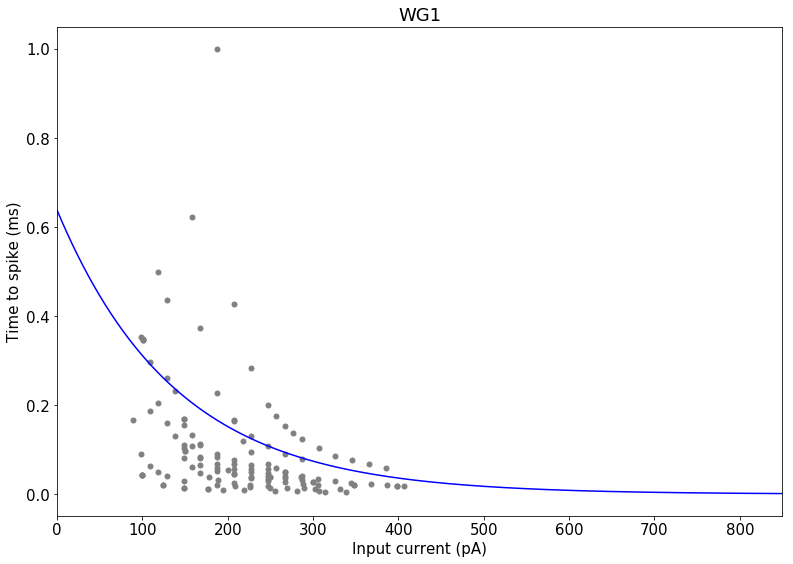

In [16]:
x=WG1_time_to_spike_input
y=WG1_time_to_spike_value

# normalise time to spike
time_to_spike_max=max(y)
y=y/time_to_spike_max

all_x=np.linspace(0,850,850)

plt.plot(x,y,'.',markersize=10,c='grey')
plt.plot(all_x[np.argsort(all_x)], (np.exp(WG1_coeff[0][1]) * np.exp(WG1_coeff[0][0] * all_x[np.argsort(all_x)]))/time_to_spike_max, label='Fitted line',c='blue')
#plt.ylim([-10,1100])
plt.xlim([0, 850])

plt.title('WG1')
plt.xlabel('Input current (pA)')
plt.ylabel('Time to spike (ms)')

#plt.savefig('WG1_model_time_to_spike.eps', format='eps', dpi=300)



## WG4 Time to spike

Text(0,0.5,'Time to spike (ms)')

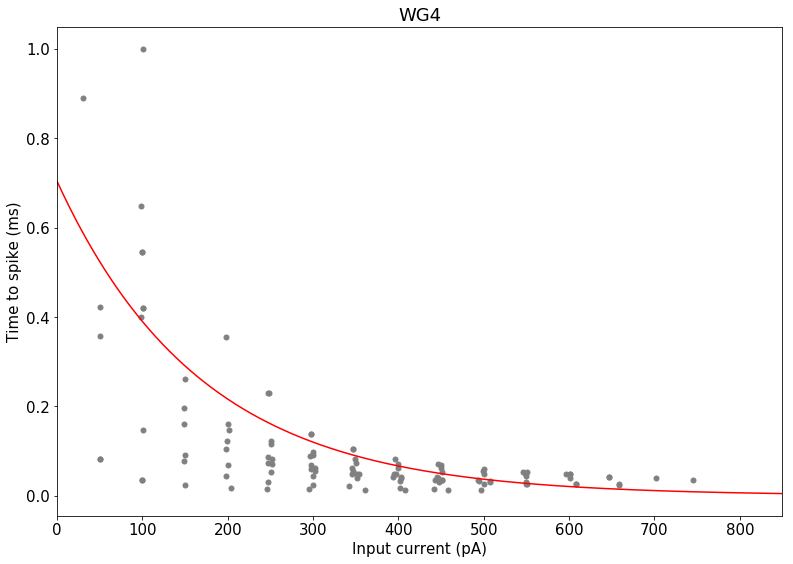

In [17]:
x=WG4_time_to_spike_input
y=WG4_time_to_spike_value

# normalise time to spike
time_to_spike_max=max(y)
y=y/time_to_spike_max


all_x=np.linspace(0,850,850)

plt.plot(x,y,'.',markersize=10,c='grey')
plt.plot(all_x[np.argsort(all_x)], (np.exp(WG4_coeff[0][1]) * np.exp(WG4_coeff[0][0] * all_x[np.argsort(all_x)]))/time_to_spike_max, label='Fitted line',c='red')
#plt.ylim([-10,1100])
plt.xlim([0, 850])

plt.title('WG4')
plt.xlabel('Input current (pA)')
plt.ylabel('Time to spike (ms)')

#plt.savefig('WG4_model_time_to_spike.eps', format='eps', dpi=300)


# Plot WG1 and WG4 f-I curves

## plot all WG1 f-I curves

In [18]:

# empty vectors for interpolation, set up the same for all experimental groups
input_interp=np.arange(0,500,1)
frequency_interp_sum=np.arange(0,500,1)*0


(-10, 500)

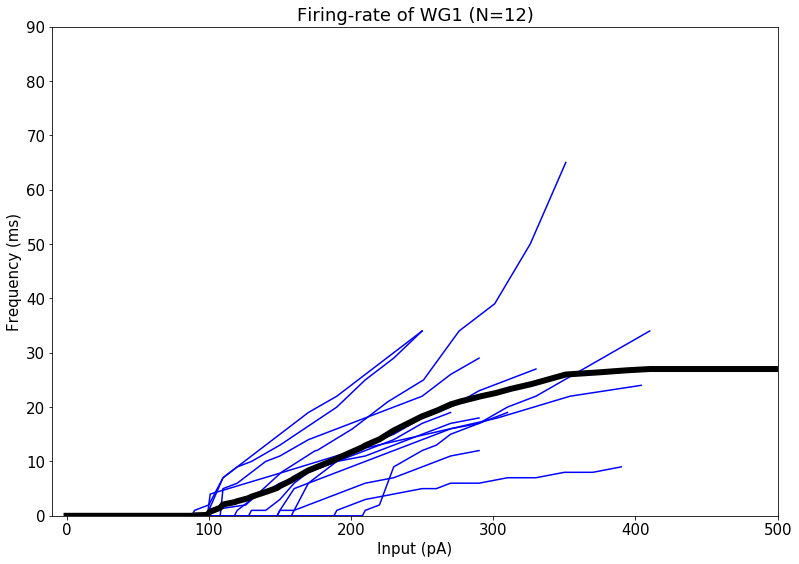

In [19]:

N_total=len(files_features_fI_WG1['input_current'])

# empty vectors for interpolation, set up the same for all experimental groups
input_interp=np.arange(0,500,1)
frequency_interp_sum=np.arange(0,500,1)*0

# WG1
for i in range(len(files_features_fI_WG1['input_current'])):
    input_cell=files_features_fI_WG1['input_current'][i]
    frequency_cell=files_features_fI_WG1['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='blue')
    

# add mean to the comparison
plt.plot(input_interp,frequency_interp_sum/N_total,c='black',linewidth=6.0)

input_interp_wg1=input_interp
frequency_interp_wg1=frequency_interp_sum/N_total                                                                                                                                                                                                                 

# data    
plt.title('Firing-rate of WG1 (N=' +str(N_total) +str(')'))
plt.xlabel('Input (pA)')
plt.ylabel('Frequency (ms)')
plt.ylim((0,90))
plt.xlim((-10, 500))

#plt.savefig('WG1_fI.eps', format='eps', dpi=300)


## plot all WG4 f-I curves

(-10, 500)

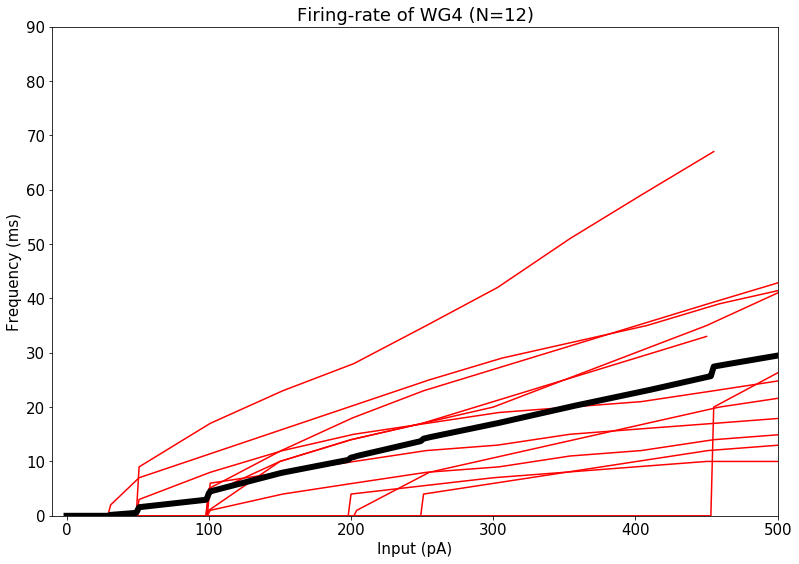

In [21]:

N_total=len(files_features_fI_WG4['input_current'])

# empty vectors for interpolation, set up the same for all experimental groups
input_interp=np.arange(0,500,1)
frequency_interp_sum=np.arange(0,500,1)*0


# WG4
for i in range(len(files_features_fI_WG4['input_current'])):
    input_cell=files_features_fI_WG4['input_current'][i]
    frequency_cell=files_features_fI_WG4['firing_frequency'][i]

    # interpolate the current
    frequency_interp=np.interp(input_interp,input_cell,frequency_cell)

    # sum up all interpolated values
    frequency_interp_sum=frequency_interp_sum+frequency_interp

    plt.plot(input_cell,frequency_cell,c='red')
    

# add mean to the comparison
plt.plot(input_interp,frequency_interp_sum/N_total,c='black',linewidth=6.0)


input_interp_wg4=input_interp
frequency_interp_wg4=frequency_interp_sum/N_total                                                                                                                                                                                                                 


# data    
plt.title('Firing-rate of WG4 (N=' +str(N_total) +str(')'))
plt.xlabel('Input (pA)')
plt.ylabel('Frequency (ms)')
plt.ylim((0,90))
plt.xlim((-10, 500))

#plt.savefig('WG4_fI.eps', format='eps', dpi=300)


## plot the averaged WG1 and WG4 curves

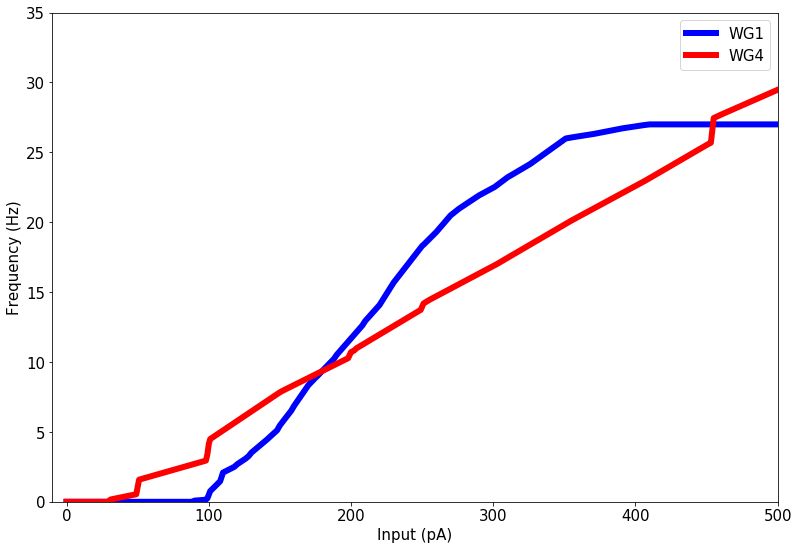

In [22]:

plt.plot(input_interp_wg1,frequency_interp_wg1,c='blue',linewidth=6.0)
plt.plot(input_interp_wg4,frequency_interp_wg4,c='red',linewidth=6.0)

# data    
#plt.title('Firing-rate of WG4 (N=' +str(N_total) +str(')'))
plt.xlabel('Input (pA)')
plt.ylabel('Frequency (Hz)')
plt.ylim((0,35))
plt.xlim((-10,500))
plt.legend(['WG1','WG4'])

#plt.savefig('WG1_WG4_fI_models.eps', format='eps', dpi=300)


# Create the data matrix based on dictionaries

In [24]:
# define the total number of cells and total number of features

keys=files_features_WG1.keys()
keys[1]

# determine the length based on one dictionary
n_features=len(files_features_WG1[keys[1]])
n_cells=len(files_features_WG1)+len(files_features_WG4)


print 'Total number of features'
print n_features
print
print 'Total number of cells'
print n_cells


Total number of features
30

Total number of cells
24


In [25]:
# create the vector of patient labeling

patient_label = np.zeros(n_cells)

n_1=len(files_features_WG1)
n_2=n_1+len(files_features_WG4)

patient_label[0:n_1]=1
patient_label[n_1:n_2]=2

print 'Patient labels'
print patient_label


Patient labels
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


# Save features to the matrix

In [26]:
# number corresponds to the Wyler grade

a,b,my_keys=matrix_from_dict(n_cells,n_features,1,files_features_WG1)
c,d,my_keys=matrix_from_dict(n_cells,n_features,4,files_features_WG4)

# concatenate the matricies
all_features_matrix=np.concatenate((a,c),axis=0)


In [27]:
# save the feature names

feature_names=my_keys
print my_keys


['adaptation_slope', 'adaptation_slope_rheobase', 'AP_through_rheobase', 'AP_downstroke_slope', 'voltage_base_mean', 'Time_to_spike_slope', 'R_in', 'First_ISI_slope', 'AP_thr_rheobase', 'AP_upstroke_slope', 'voltage_base_sigma', 'AP_through_slope', 'Time_to_spike_slope_rheobase', 'AP_height_slope', 'AP_downstroke_rheobase', 'AP_up/downstroke_rheobase', 'taum_mean', 'mean_ISI_slope', 'AP_width_slope', 'AP_thr_slope', 'First_ISI_slope_rheobase', 'AP_height_rheobase', 'AP_up/downstroke_slope', 'AP_width_rheobase', 'mean_ISI_slope_rheobase', 'AP_upstroke_rheobase', 'taum_sigma', 'Rheobase_current', 'fI_slope', 'Rheobase_freq']


In [28]:
# save cell names

cell_names=b+d
print cell_names


['1706015210901.nwb', '1706015210904.nwb', '1706014110704.nwb', '1706015210902.nwb', '1706015210906.nwb', '1706015210802.nwb', '1706014110202.nwb', '1706014110201.nwb', '1706015210907.nwb', '1706014110703.nwb', '1706014110502.nwb', '1706015211001.nwb', '1606013050102.nwb', '1706012211205.nwb', '1706012210308.nwb', '1606013050103.nwb', '1706012210501.nwb', '1706012211201.nwb', '1606013050501.nwb', '1606013050504.nwb', '1606013050301.nwb', '1706012210502.nwb', '1706012210307.nwb', '1706012210403.nwb']


# Vizualise the matrix of extracted features

Text(0.5,1,'Concatenated matrix of features')

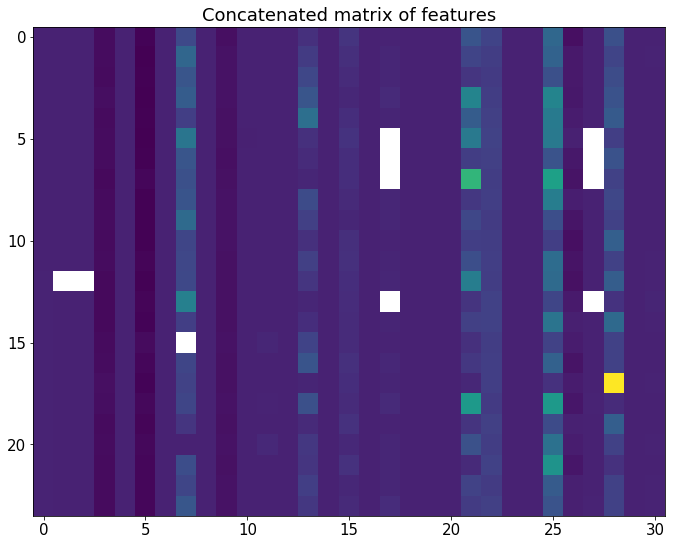

In [29]:
plt.imshow(all_features_matrix)
plt.title('Concatenated matrix of features')

# Save features, names and labels to csv file

In [31]:

# save the data matrix to csv
np.savetxt('ALL_EPHYS_FEATURES_MODELS_hipp_GC.csv',all_features_matrix, delimiter=" ")

# save the cell_type names
with open('ALL_EPHYS_FEATURES_MODELS_NAMES_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(cell_names)
    
# save the patient labels
with open('ALL_EPHYS_FEATURES_MODELS_LABELS_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(patient_label)
    
# save the feature names
with open('ALL_EPHYS_FEATURES_MODELS_FEATURE_NAMES_hipp_GC.csv', 'wb') as myfile:
    wr = csv.writer(myfile, dialect='excel')
    wr.writerow(feature_names)
    